<a href="https://colab.research.google.com/github/dchung117/pokedex/blob/master/trainPokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Clone repository

In [1]:
!git clone https://github.com/dchung117/pokedex.git
!cd pokedex

Cloning into 'pokedex'...
remote: Enumerating objects: 235044, done.
remote: Total 235044 (delta 0), reused 0 (delta 0), pack-reused 235044
Receiving objects: 100% (235044/235044), 9.47 GiB | 39.49 MiB/s, done.
Resolving deltas: 100% (644/644), done.
Checking out files: 100% (2984/2984), done.


In [1]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

import torch
from torch import nn, flatten, optim
from torch.nn import Conv2d, BatchNorm2d, ReLU, Sequential, MaxPool2d, AdaptiveAvgPool2d, Linear
from torch.nn.init import kaiming_normal_, constant_
from torch.nn.functional import cross_entropy

In [3]:
#  Create image folder of scraped images
root = '/content/pokedex'
imgs_path = os.path.join(root, 'poke_imgs')

#  Resize and normalize images
poke_imgs = ImageFolder(imgs_path)

#  Create dictionary mapping pokemon IDs to their sparse representations
poke_dict = {v:k for k,v in poke_imgs.class_to_idx.items()}

In [4]:
#  Count number of images per Pokemon
poke_counter = Counter([x for x in poke_imgs.targets])
for pc in poke_counter:
    print(poke_dict[pc].capitalize(), poke_counter[pc])

Blastoise 333
Bulbasaur 340
Charizard 396
Charmander 335
Charmeleon 307
Ivysaur 307
Squirtle 345
Venusaur 335
Wartortle 271


## Generate training, validation, test set indices (save indices if continuing work on the same train-val-test split).

In [5]:
#  For each pokemon, divide number of images into training and test sets
val_test_split = 0.2
rand_seed = 25
np.random.seed(rand_seed)
train_idxs = []
val_idxs = []
test_idxs = []

pc_start_idx = 0
pc_stop_idx = 0
for pc in poke_counter:
    print('Sampling validation and test set images for ', poke_dict[pc].capitalize())

    #  Get stop index and number of validation/test images to add
    pc_stop_idx += poke_counter[pc]
    print(pc_start_idx, pc_stop_idx)
    split_ct = int(np.floor(val_test_split * poke_counter[pc]))
    pc_idxs = np.arange(pc_start_idx, pc_stop_idx)

    #  Randomly select test set indices
    pc_split_idxs = np.random.choice(pc_idxs, 2*split_ct, replace=False)
    np.random.shuffle(pc_split_idxs)

    #  Assign training, validation and test set indices
    pc_train_idxs = np.array(list(set(pc_idxs) - set(pc_split_idxs)))
    pc_val_idxs = pc_split_idxs[:split_ct]
    pc_test_idxs = pc_split_idxs[split_ct+1:]

    #  Append indices to train/test arrays
    train_idxs.append(pc_train_idxs)
    val_idxs.append(pc_val_idxs)
    test_idxs.append(pc_test_idxs)

    #  Increment start index for next pokemon
    pc_start_idx += poke_counter[pc]

train_idxs = np.concatenate(train_idxs)
val_idxs = np.concatenate(val_idxs)
test_idxs = np.concatenate(test_idxs)

#  Save train, val, test indices (create indices directory, save each numpy object)
idx_dict = {'train': train_idxs, 'val': val_idxs, 'test': test_idxs}

Sampling validation and test set images for  Blastoise
0 333
Sampling validation and test set images for  Bulbasaur
333 673
Sampling validation and test set images for  Charizard
673 1069
Sampling validation and test set images for  Charmander
1069 1404
Sampling validation and test set images for  Charmeleon
1404 1711
Sampling validation and test set images for  Ivysaur
1711 2018
Sampling validation and test set images for  Squirtle
2018 2363
Sampling validation and test set images for  Venusaur
2363 2698
Sampling validation and test set images for  Wartortle
2698 2969


In [97]:
#  Check train, val, test split
idx_path = os.path.join('/content/pokedex/data_indices/train_val_test_indices.npy')
idx_dict = np.load(idx_path, allow_pickle=True).item()

train_idxs = idx_dict['train']
val_idxs = idx_dict['val']
test_idxs = idx_dict['test']

print('Training split: ', f"{train_idxs.size/len(poke_imgs):.3f}")
print('Validation split: ', f"{val_idxs.size/len(poke_imgs):.3f}")
print('Test split: ', f"{test_idxs.size/len(poke_imgs):.3f}")

Training split:  0.601
Validation split:  0.199
Test split:  0.196


In [98]:
#  Create dataset class that will load data from the image directory. Additional functionalities are included for training, validation, test sets.
class PokemonImageDataset(Subset):

    def __init__(self, ds, indices, ds_type, aug_flag=False, aug_list=[], aug_mult=1, scaled=True):
        super().__init__(ds, indices) #  self.dataset = ds, self.indices = indices
        #  Catch any initialization errors
        assert (ds_type in ['train', 'val', 'test']), 'aug_flag must be either "train", "val", "test".'
        assert (isinstance(aug_list, list)), 'aug_list must be a list of data augmentations'
        assert (aug_mult > 0), 'aug_mult must be positive.'
        assert (isinstance(scaled, bool)), 'scaled must be a Boolean variable.'
        if ds_type in ['val', 'test']:
            assert (aug_flag == False and aug_mult == 1), 'augmentation only allowed for ds_type "train".'
            assert (aug_mult == 1), 'augmentation only allowed for ds_type "train".'
        if aug_flag:
            assert (aug_list), 'must provide list of data augmentations (aug_list).'

        #  Set attributes of dataset class
        self.ds_type = ds_type
        self.aug_flag = aug_flag
        self.aug_list = aug_list
        if self.aug_flag:
            self.aug_mult = aug_mult
        else:
            self.aug_mult = 0
        self.scaled = scaled
    
    def __getitem__(self, index):
        #  Check that the index is in bounds
        assert (index <= len(self) - 1), 'Index is out of bounds.'

        def get_orig_img(index, scaled):
            sub_idx = self.indices[index]
            img, label = self.dataset[sub_idx]

            #  Scale (if specified)
            if scaled:
                trans_func = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            else:
                trans_func = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
            img = trans_func(img)

            return img, label

        #  If data augmentation is implemented
        if self.aug_flag:
            if index // (len(self.indices) - 1):
                #  Get image to augment
                aug_idx = index % (len(self.indices)-1)
                img, label = self.dataset[self.indices[aug_idx]]

                #  Apply random transformation to the image
                aug_func = transforms.RandomChoice(self.aug_list)
                if self.scaled:
                    trans_func = transforms.Compose([aug_func, transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                else:
                    trans_func = transforms.Compose([aug_func, transforms.Resize((224, 224)), transforms.ToTensor()])
                img = trans_func(img)
    
                return img, label

            else:
                img, label = get_orig_img(index, self.scaled)
                return img, label

        #  If no augmentation implemented
        else:
            img, label = get_orig_img(index, self.scaled)
            return img, label

    def __len__(self):
        if self.aug_flag:
            return len(self.indices) + int(len(self.indices))*self.aug_mult
        else:
            return len(self.indices)

In [99]:
#  Create list of transformations to augment training set
horz_flip = transforms.RandomHorizontalFlip(p=1)

crop_sz = 128
center_crop = transforms.CenterCrop(crop_sz)
rand_crop = transforms.RandomResizedCrop(crop_sz)
def crop_choice(crop_type, crop_size):
    """Function wrapper that returns a crop function (center, random, or ten-crop pick)."""
    if crop_type == 'center':
        def center_crop(img):
            crop_sz = min(min(img.size), crop_size)
            crop_func = transforms.CenterCrop(size=crop_sz)
            return crop_func(img)
        return center_crop

    if crop_type == 'rand':
        def rand_crop(img):
            crop_sz = min(min(img.size), crop_size)
            crop_func = transforms.RandomResizedCrop(size=crop_sz)
            return crop_func(img)
        return rand_crop

    if crop_type == 'ten':
        def rand_ten_crop(img):
            crop_sz = min(min(img.size), crop_size)
            crop_func = transforms.TenCrop(size=crop_sz)
            ten_crops = crop_func(img)
            crop_idx = np.random.choice(len(ten_crops))
            return ten_crops[crop_idx]
        return rand_ten_crop

aug_list = [horz_flip, crop_choice('center', crop_sz), crop_choice('rand', crop_sz), crop_choice('ten', crop_sz)]

#  Create training, validation, and test sets
train_set = PokemonImageDataset(ds=poke_imgs, indices=train_idxs, ds_type='train', scaled=True)
val_set = PokemonImageDataset(ds=poke_imgs, indices=val_idxs, ds_type='val', scaled=True)
test_set = PokemonImageDataset(ds=poke_imgs, indices=test_idxs, ds_type='test', scaled=True)

In [100]:
#  Check for overlaps 
print('Training set overlaps', np.isin(train_set.indices, val_set.indices).any(), np.isin(train_set.indices, test_set.indices).any())
print('Validation set overlaps', np.isin(val_set.indices, train_set.indices).any(), np.isin(val_set.indices, test_set.indices).any())
print('Test set overlaps', np.isin(test_set.indices, train_set.indices).any(), np.isin(test_set.indices, val_set.indices).any())

Training set overlaps False False
Validation set overlaps False False
Test set overlaps False False


In [101]:
#  Create dataloaders for training, validation, test sets
train_bs = 32
val_bs = 32
test_bs = 32

#  NOTE: when trainig on GPU, need to pass arguments for num_workers, pin_memory
train_loader = DataLoader(train_set, batch_size=train_bs, shuffle=True)
val_loader = DataLoader(val_set, batch_size=val_bs, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_bs, shuffle=True)

tensor([1, 5, 6, 8, 7, 1, 2, 0, 5, 6, 2, 6, 8, 6, 4, 0, 2, 7, 2, 2, 7, 2, 0, 4,
        5, 2, 2, 1, 1, 8, 5, 0])


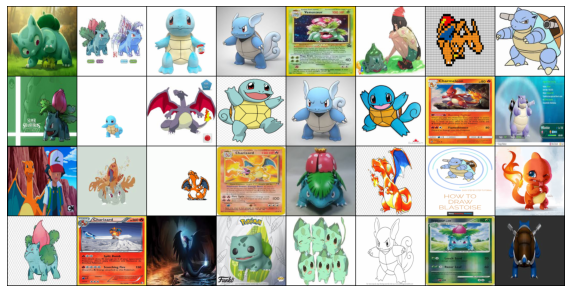

In [102]:
b_num=0
for (b_imgs, b_labels) in train_loader:
    # if b_num < len(train_loader)-1:
    #     b_num += 1
    #     continue
    img_grid = make_grid(b_imgs, nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    print(b_labels)
    break

Create the ResNet50 class.

Create bottleneck class to create the novel "residual" module <br /> <br /> Source: (https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [103]:
def check_conv_params(conv_params):
    """Checks the argument 'conv_params' for errors."""
    assert(isinstance(conv_params, dict)), conv_params + ' must be a dictionary containing parameters.'
    params_req = ['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'bias']
    assert(all([p in params_req for p in conv_params])), 'Need to specify ' + ', '.join(params_req) + '.'

def check_norm_feats(norm_feats):
    """Checks the argument 'norm_feats' for errors."""
    assert(isinstance(norm_feats, int)), norm_feats + ' must be an integer specifying the number of features (channels) for batch normalization.'
    assert(norm_feats > 0), norm_feats + ' must be a positive integer.'

class Bottleneck(nn.Module):

    expansion = 4
    def __init__(self, conv1_params, norm1_feats, conv2_params, norm2_feats, conv3_params, norm3_feats, act_func=ReLU(inplace=True), 
                dsmp=False, dsmp_conv_params=None, dsmp_norm_feats=None):
        super(Bottleneck, self).__init__()
        
        #  Run error checks on all arguments
        module_args = locals().copy()
        for arg in module_args:
            if arg[0:4] == 'conv':
                check_conv_params(module_args[arg])
            elif arg[0:4] == 'norm':
                check_norm_feats(module_args[arg])
            elif arg[0:4] == 'dsmp':
                if module_args[arg] is None:
                    continue
                elif 'conv' in arg:
                    check_conv_params(module_args[arg])
                elif 'norm' in arg:
                    check_norm_feats(module_args[arg])
                else: #  check 'dsmp' boolean argument
                    assert(isinstance(module_args[arg], bool)), arg + ' must be a boolean.'

        #  Compression Layer (Dimensionality Reduction)
        self.conv1_params = conv1_params
        self.conv1 = Conv2d(**self.conv1_params)
        self.norm1_feats = norm1_feats
        self.norm1 = BatchNorm2d(self.norm1_feats)

        #  Downsampling Layer (i.e. learn localized patterns and shrink feature maps)
        self.conv2_params = conv2_params
        self.conv2 = Conv2d(**self.conv2_params)
        self.norm2_feats = norm2_feats
        self.norm2 = BatchNorm2d(self.norm2_feats)

        #  Expansion Layer (Dimensionality Increase)
        self.conv3_params = conv3_params
        self.conv3 = Conv2d(**self.conv3_params)
        self.norm3_feats = norm3_feats
        self.norm3 = BatchNorm2d(self.norm3_feats)

        #  Additional Downsampling Layer (i.e. processing layer to match number of feature maps and feature map sizes to bottleneck output)
        self.dsmp = dsmp
        if self.dsmp:
            self.dsmp_conv_params = dsmp_conv_params
            self.dsmp_conv = Conv2d(**self.dsmp_conv_params)
            self.dsmp_norm_feats = dsmp_norm_feats
            self.dsmp_norm = BatchNorm2d(self.dsmp_norm_feats)

        #  Activation function
        self.act_func = act_func

    def forward(self, x):
        #  Store input tensor
        identity = x

        #  Compression Layer
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.act_func(out)

        #  Downsampling Layer
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.act_func(out)

        #  Expansion Layer 
        out = self.conv3(out)
        out = self.norm3(out)

        #  Additional Downsampling Layer (if applicable)
        if self.dsmp:
            identity = self.dsmp_conv(x)
            identity = self.dsmp_norm(identity)

        #  Residual Summation
        out += identity

        # Apply activation function
        out = self.act_func(out)
  
        return out

In [105]:
def make_conv_dict(in_chls, out_chls, k_sz, stride, pad, bias):
    """Returns a dictionary of arguments for the Conv2d blocks."""
    return {'in_channels': in_chls, 'out_channels': out_chls, 'kernel_size': k_sz, 'stride': stride, 'padding': pad, 'bias': bias}

def build_res_layers(layer_num, in_chls=64):
    #  Check for errors in arguments
    assert(layer_num in [1, 2, 3, 4]), 'Only four residual layers in ResNet50 model architecture.'
    assert(in_chls >= 64), 'Number of input channels after image pre-processing must be at least 64.'

    #  Construct bottleneck layer w/ downsampling
    dim_red_sz = int(max(in_chls/2, 64)) #  Get num of dimensions after dimensionality reduction
    dim_exp_sz = dim_red_sz * 4 #  Get num of dimensions after dimensionality expansion

    if layer_num == 1:
        ds_stride = 1 #  No downsampling for residual layer 1
    else:
        ds_stride = 2
    
    ds_conv1_params = make_conv_dict(in_chls=in_chls, out_chls=dim_red_sz, k_sz=1, stride=1, pad=0, bias=False) #  dimensionality reduction
    ds_conv2_params = make_conv_dict(in_chls=dim_red_sz, out_chls=dim_red_sz, k_sz=3, stride=ds_stride, pad=1, bias=False) #  downsampling
    ds_conv3_params = make_conv_dict(in_chls=dim_red_sz, out_chls=dim_exp_sz, k_sz=1, stride=1, pad=0, bias=False) #  dimensionality expansion
    ds_conv_params = make_conv_dict(in_chls=in_chls, out_chls=dim_exp_sz, k_sz=1, stride=ds_stride, pad=0, bias=False) #  input downsampling

    ds_bottle = Bottleneck(conv1_params=ds_conv1_params, norm1_feats=dim_red_sz, conv2_params=ds_conv2_params, norm2_feats=dim_red_sz, conv3_params=ds_conv3_params, norm3_feats=dim_exp_sz, 
                        dsmp=True, dsmp_conv_params=ds_conv_params, dsmp_norm_feats=dim_exp_sz)
    
    #  Construct bottleneck layer w/o downsampling
    conv1_params = make_conv_dict(in_chls=dim_exp_sz, out_chls=dim_red_sz, k_sz=1, stride=1, pad=0, bias=False)
    conv2_params = make_conv_dict(in_chls=dim_red_sz, out_chls=dim_red_sz, k_sz=3, stride=1, pad=1, bias=False)
    conv3_params = make_conv_dict(in_chls=dim_red_sz, out_chls=dim_exp_sz, k_sz=1, stride=1, pad=0, bias=False)

    bottle = Bottleneck(conv1_params=conv1_params, norm1_feats=dim_red_sz, conv2_params=conv2_params, norm2_feats=dim_red_sz, conv3_params=conv3_params, norm3_feats=dim_exp_sz)

    #  Return a sequence of modules (depending on layer number)
    if layer_num in [1, 4]: #  2 standard bottlenecks
        bottle_list = [ds_bottle] + list(map(deepcopy, [bottle]*2))
        return Sequential(*bottle_list)
    elif layer_num == 2: #  3 standard bottlenecks
        bottle_list = [ds_bottle] + list(map(deepcopy, [bottle]*3))
        return Sequential(*bottle_list)
    elif layer_num == 3: #  5 standard bottlenecks
        bottle_list = [ds_bottle] + list(map(deepcopy, [bottle]*5))
        return Sequential(*bottle_list)

In [106]:
import torchvision.models as models

class ResNet50(nn.Module):
    def __init__(self, num_classes, layer1, layer2, layer3, layer4, pretrained=True, zero_init_residuals=False, verbose=True):
        super(ResNet50, self).__init__()
        
        #  Pre-processing (downsample original image size and expand dimensions)
        self.conv1 = Conv2d(3, 64, kernel_size=7, stride=2,  padding=3, bias=False) # downsample by 1/2
        self.bn1 = BatchNorm2d(64)
        self.relu = ReLU(inplace=True)
        self.maxpool = MaxPool2d(kernel_size=3, stride=2, padding=1) #  downsample by 1/2 

        #  Four Residual Layers - each layer contains series of bottleneck layers
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        self.layer4 = layer4

        #  Global Average Pooling - compute averages for each feature map after final residual layer
        self.avgpool = AdaptiveAvgPool2d(output_size=(1, 1))

        #  Fully Connected Layer - used to compute class probabilities
        self.fc = Linear(512 * 4, num_classes)

        #  Flag to load pretrained weights
        self.pretrained = pretrained
        self.verbose = verbose

        def __print_status(*msg):
            if self.verbose:
                print(*msg)

        #  Load ResNet50 state_dict and update state_dict
        if self.pretrained:
            __print_status('Loading ImageNet weights of ResNet50...')
            res50 = models.resnet50(pretrained=True)
            res50_state_dict = {}
            for p, q in zip(self.state_dict(), res50.state_dict()):
                if 'fc' in p and 'fc' in q:
                    __print_status('Randomly initializing fully connected layers', p, q)
                    if 'weight' in p and 'weight' in q:
                        res50_state_dict[p] = torch.rand(num_classes, 512 * 4, dtype=torch.float, requires_grad=True)
                    elif 'bias' in p and 'bias' in q:
                        res50_state_dict[p] = torch.rand(num_classes, dtype=torch.float, requires_grad=True)
                elif p == q:
                    res50_state_dict[p] = res50.state_dict()[q]
                elif 'norm' in p.split('.')[2] and 'bn' in q.split('.')[2]:
                    __print_status('Batch norm ', p, q)
                    res50_state_dict[p] = res50.state_dict()[q]
                elif p.split('.')[2] == 'dsmp_conv' and q.split('.')[2:4] == ['downsample', '0']:
                    __print_status('Downsample convolution ', p, q)
                    res50_state_dict[p] = res50.state_dict()[q]
                elif p.split('.')[2] == 'dsmp_norm' and q.split('.')[2:4] in [['downsample', '0'], ['downsample', '1']]:
                    __print_status('Downsample batch norm ', p, q)
                    res50_state_dict[p] = res50.state_dict()[q]
                else: 
                    raise NameError(p, q, ' are incompatible.')
            self.load_state_dict(res50_state_dict)
            print()

            #  Set all parameters (besides fully connected layer) to be untrainable
            __print_status('Only training fully connected layer...')
            batchnorm_strs = ['running_mean', 'running_var', 'num_batches_tracked']
            param_state_dict = [x_name for x_name in self.state_dict() if not any([bn_str in x_name for bn_str in batchnorm_strs])]
            for param, param_name in zip(self.parameters(), param_state_dict):
                if 'fc' in param_name:
                    __print_status(param_name, 'requires gradient.')
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        
        #  Initialize model weights before training entire ResNet50 model
        else:
            __print_status('Initializing layer weights and biases...')
            for m in self.modules():
                if isinstance(m, Conv2d): #  Normalize convolutional layer weights
                    kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, BatchNorm2d): #  Initialize batch normalization weights and biases 
                    constant_(m.weight, 1)
                    constant_(m.bias, 0)

            #  Initiailize last batch normalization weights to 0 (optionally convert residual layer into an identity function -> add input to output)
            if zero_init_residuals: 
                __print_status('Zero-initializing weights of last batch normalization layer for each bottleneck module...') 
                for m in self.modules():
                    if isinstance(m, Bottleneck):
                        constant_(m.norm3.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = flatten(x, 1)
        x = self.fc(x)
  
        return x

In [108]:
#  Create ResNet50 network
num_classes = len(poke_dict)
layer1 = build_res_layers(1)
layer2 = build_res_layers(2, in_chls=256)
layer3 = build_res_layers(3, in_chls=512)
layer4 = build_res_layers(4, in_chls=1024)

res_50 = ResNet50(num_classes, layer1, layer2, layer3, layer4, pretrained=True, verbose=True)

Loading ImageNet weights of ResNet50...
Batch norm  layer1.0.norm1.weight layer1.0.bn1.weight
Batch norm  layer1.0.norm1.bias layer1.0.bn1.bias
Batch norm  layer1.0.norm1.running_mean layer1.0.bn1.running_mean
Batch norm  layer1.0.norm1.running_var layer1.0.bn1.running_var
Batch norm  layer1.0.norm1.num_batches_tracked layer1.0.bn1.num_batches_tracked
Batch norm  layer1.0.norm2.weight layer1.0.bn2.weight
Batch norm  layer1.0.norm2.bias layer1.0.bn2.bias
Batch norm  layer1.0.norm2.running_mean layer1.0.bn2.running_mean
Batch norm  layer1.0.norm2.running_var layer1.0.bn2.running_var
Batch norm  layer1.0.norm2.num_batches_tracked layer1.0.bn2.num_batches_tracked
Batch norm  layer1.0.norm3.weight layer1.0.bn3.weight
Batch norm  layer1.0.norm3.bias layer1.0.bn3.bias
Batch norm  layer1.0.norm3.running_mean layer1.0.bn3.running_mean
Batch norm  layer1.0.norm3.running_var layer1.0.bn3.running_var
Batch norm  layer1.0.norm3.num_batches_tracked layer1.0.bn3.num_batches_tracked
Downsample convolu

## Set up functions for training, validation, testing.

In [109]:
#  Get current device; load model onto current device
def get_device():
    """Returns the current device (CUDA if available, else CPU)."""
    current_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Current device: ', current_device)
    return current_device

device = get_device()
res_50.to(device)

Current device:  cuda:0


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dsmp_conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (dsmp_norm): BatchNorm2d(256,

In [110]:
#  Create functions to load data on to device
def load_data(data, device):
    """Load data to the current device."""
    if isinstance(data, (list, tuple)):
        return [load_data(d, device) for d in data]
    return data.to(device, non_blocking=True)

def data_generator(data_loader, device):
    """Convert a dataloader into a generator that loads data onto GPU one batch at a time."""
    for b in data_loader:
        yield load_data(b, device)

##  Train the model (skip to next section if already trained)

In [111]:
#  Train/validation step
def train_step(train_loader, data_generator, device, model, optimizer):
    """Compute the average training loss for a batch."""
    train_losses = []
    for b_imgs, b_labels in data_generator(train_loader, device):
        out = model(b_imgs)
        train_loss = cross_entropy(out, b_labels) #  Compute losses in forward pass
        train_losses.append(train_loss.detach())

        train_loss.backward() #  Compute gradients
        optimizer.step() #  Update parameters
        optimizer.zero_grad() #  Reset gradients
    
    return train_losses

@torch.no_grad()
def val_step(val_loader, data_generator, device, model):
    """Compute the average validation losses for a batch."""
    val_losses = []
    val_accuracies = []

    for b_imgs, b_labels in data_generator(val_loader, device):
        #  Compute validation losses
        out = model(b_imgs)
        val_loss = cross_entropy(out, b_labels)
        val_losses.append(val_loss.detach())

        #  Compute validation accuracies
        _, b_preds = torch.max(out, dim=1)
        val_acc = torch.sum(b_preds == b_labels)/float(torch.numel(b_preds))
        val_accuracies.append(val_acc.detach())
    
    return val_losses, val_accuracies

def summarize_epoch_stats(train_losses, val_losses, val_accuracies):
    """Compute the average training/validation losses and validation accuracies of the epoch."""
    avg_train_loss = torch.stack(train_losses).mean().item()
    avg_val_loss = torch.stack(val_losses).mean().item()
    avg_val_acc = torch.stack(val_accuracies).mean().item()

    return {'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc': avg_val_acc}

def epoch_end(e, e_summary):
    """Print average metrics at the end of an epoch."""
    print('Epoch: ', str(e), 'train_loss: ', f"{e_summary['train_loss']:.4f}", 'val_loss: ', f"{e_summary['val_loss']:.4f}", 'val_acc: ', f"{e_summary['val_acc']:.4f}")

def train_model(epochs, lr, model, data_generator, device, train_loader, val_loader, opt_func=optim.Adam, tl_type='fe'):
    torch.cuda.empty_cache()
    history = []

    #  Pass trainable parameters to optimizer
    if model.pretrained:
        assert tl_type in ['fe', 'ft'], 'Transfer learning type must be either feature extraction (fe) or fine-tuning (ft).'
        if tl_type == 'fe':
            param_list = [p for p in model.parameters() if p.requires_grad]
            optimizer = opt_func(param_list, lr=lr)
        else:
            for p in model.parameters():
                p.requires_grad=True
            optimizer = opt_func(model.parameters(), lr=lr)
    else:
        optimizer = opt_func(model.parameters(), lr=lr)
    
    best_acc = None
    for e in range(epochs):
        e_stats = {}
        #  Training step
        model.train()
        train_losses = train_step(train_loader, data_generator, device, model, optimizer)
        
        #  Validation step
        model.eval()
        val_losses, val_accuracies = val_step(val_loader, data_generator, device, model)

        #  Collect epoch statistics
        e_summary = summarize_epoch_stats(train_losses, val_losses, val_accuracies)
        history.append(e_summary)
        epoch_end(e, e_summary)

        #  Save parameters of best model
        if best_acc is None or best_acc < e_summary['val_acc']:
          best_acc = e_summary['val_acc']
          ckpt = {'epoch': e, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'best_val_acc': best_acc}
  
    return history, ckpt

In [112]:
#  Train for 100 epochs online (lr=0.001)
epochs=100
lr=0.001
history, ckpt = train_model(epochs=epochs, lr=lr, model=res_50, data_generator=data_generator, device=device, train_loader=train_loader, val_loader=val_loader, opt_func=optim.Adam, tl_type='ft')

Epoch:  0 train_loss:  4.2523 val_loss:  2.5571 val_acc:  0.5148
Epoch:  1 train_loss:  1.1538 val_loss:  0.9572 val_acc:  0.6990
Epoch:  2 train_loss:  0.5352 val_loss:  0.8035 val_acc:  0.7582
Epoch:  3 train_loss:  0.3419 val_loss:  0.9982 val_acc:  0.7796
Epoch:  4 train_loss:  0.2449 val_loss:  1.1367 val_acc:  0.7401
Epoch:  5 train_loss:  0.1783 val_loss:  0.9521 val_acc:  0.7780
Epoch:  6 train_loss:  0.1422 val_loss:  0.7220 val_acc:  0.8289
Epoch:  7 train_loss:  0.0802 val_loss:  1.0640 val_acc:  0.7812
Epoch:  8 train_loss:  0.0536 val_loss:  0.8587 val_acc:  0.8306
Epoch:  9 train_loss:  0.0838 val_loss:  0.7021 val_acc:  0.8421
Epoch:  10 train_loss:  0.0546 val_loss:  0.7541 val_acc:  0.8191
Epoch:  11 train_loss:  0.0764 val_loss:  0.9416 val_acc:  0.7780
Epoch:  12 train_loss:  0.1162 val_loss:  0.9761 val_acc:  0.7928
Epoch:  13 train_loss:  0.1304 val_loss:  1.5857 val_acc:  0.7286
Epoch:  14 train_loss:  0.1141 val_loss:  1.2590 val_acc:  0.7780
Epoch:  15 train_los

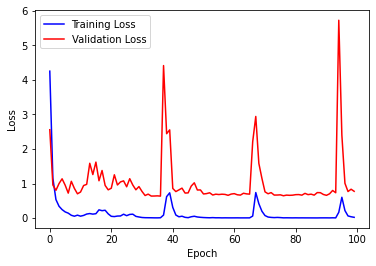

In [114]:
#  Plot train_loss, val_loss
train_losses = [h['train_loss'] for h in history]
val_losses = [h['val_loss'] for h in history]
val_accs = [h['val_acc'] for h in history]

plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
# plt.show()

#  Save loss curve
plots_path = '/content/pokedex/plots'

loss_path = os.path.join(plots_path, 'res50_ft_data_eps100_lr0001_losses.png')
plt.savefig(loss_path)

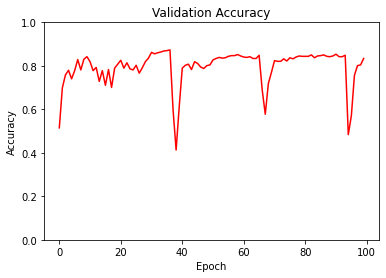

In [116]:
#  Plot val_acc
plt.plot(val_accs, '-r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.ylim([0, 1])
# plt.show()

#  Save accuracy curve
acc_path = os.path.join(plots_path, 'res50_ft_data_eps100_lr0001_valacc.png')
plt.savefig(acc_path)

In [117]:
#  Save checkpoint for best model
ckpt_path = '/content/pokedex/res50_ckpts'
save_path = os.path.join(ckpt_path, 'res50_ft_data_eps100_lr0001_ckpt.pt')

torch.save(ckpt, save_path)

## Load parameters of best trained model, evaluate model performance against test set

In [118]:
#  Import model parameters, load state dict
ckpt_path = '/content/pokedex/res50_ckpts'
load_path = os.path.join(ckpt_path, 'res50_ft_data_eps100_lr0001_ckpt.pt')

res50_ckpt = torch.load(load_path)
res_50.load_state_dict(res50_ckpt['state_dict'])

<All keys matched successfully>

In [119]:
#  Compute test loss, test accuracy
@torch.no_grad()
def test_step(model, test_loader, data_generator, device):
  """Evaluate test set against model. Compute test set losses and accuracy."""
  torch.cuda.empty_cache()

  batch_losses = []
  batch_accs = []
  test_labels = []
  test_preds = []
  
  model.eval() 
  for (b_imgs, b_labels) in data_generator(test_loader, device):
    #  Compute batch loss
    out = model(b_imgs)
    test_loss = cross_entropy(out, b_labels)
    batch_losses.append(test_loss.detach())

    #  Compute batch accuracy
    _, b_preds = torch.max(out, dim=1)
    test_acc = torch.sum(b_preds == b_labels)/float(torch.numel(b_preds))
    batch_accs.append(test_acc.detach())

    #  Collect predictions and labels
    test_labels.append(b_labels.detach().cpu().numpy())
    test_preds.append(b_preds.detach().cpu().numpy())
  
  #  Compute average test loss and accuracy
  avg_loss = torch.stack(batch_losses).mean().item()
  avg_acc = torch.stack(batch_accs).mean().item()
  print('Average test loss:', avg_loss)
  print('Average test accuracy:', avg_acc)

  test_labels = np.concatenate(test_labels, axis=0).flatten()
  test_preds = np.concatenate(test_preds, axis=0).flatten()

  return avg_loss, avg_acc, test_preds, test_labels

In [120]:
test_loss, test_acc, test_preds, test_labels = test_step(res_50, test_loader, data_generator, device)

Average test loss: 0.5748891234397888
Average test accuracy: 0.8435150980949402


In [121]:
poke_dict

{0: 'blastoise',
 1: 'bulbasaur',
 2: 'charizard',
 3: 'charmander',
 4: 'charmeleon',
 5: 'ivysaur',
 6: 'squirtle',
 7: 'venusaur',
 8: 'wartortle'}

In [122]:
#  Compute and plot confusion matrix
from sklearn.metrics import confusion_matrix

poke_labels = [poke_imgs.class_to_idx[x] for x in ['bulbasaur', 'ivysaur', 'venusaur', 'charmander', 'charmeleon', 'charizard', 'squirtle', 'wartortle', 'blastoise']] 
cm = confusion_matrix(y_true=test_labels, y_pred=test_preds, labels=poke_labels, normalize='true')

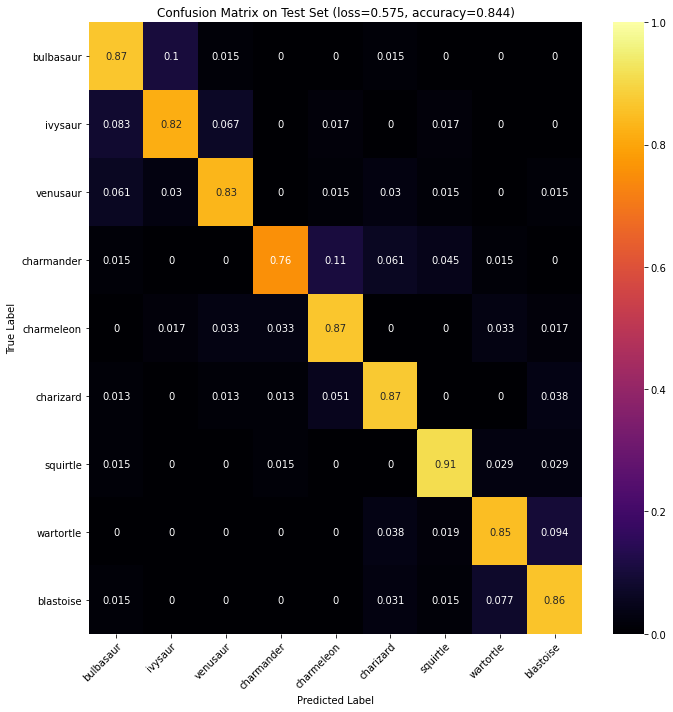

In [124]:
#  Plot confusion matrix
from seaborn import heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax = heatmap(cm, vmin=0.0, vmax=1.0, cmap='inferno', annot=True, xticklabels=[poke_dict[x] for x in poke_labels], yticklabels=[poke_dict[x] for x in poke_labels])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Confusion Matrix on Test Set (loss={loss:.3f}, accuracy={acc:.3f})".format(loss=test_loss, acc=test_acc))
fig.tight_layout()

# Save confusion matrix
cm_path = os.path.join('/content/pokedex/plots/', 'res50_ft_data_eps100_lr0001_testcmat.png')
plt.savefig(cm_path)